У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveDrift, XGBModel, ExponentialSmoothing, ARIMA, AutoARIMA, RNNModel 
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from pmdarima import auto_arima
from darts.metrics import rmse
from darts.metrics import mae as mae_metric, mape as mape_metric
from statsmodels.graphics.tsaplots import plot_pacf
from darts.utils.statistics import plot_acf, check_seasonality
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
from functools import reduce


In [2]:
def plot_forecasts(train, val=None, preds=None, time_col=None, value_col=None, title="Forecast Plot"):
    """
    Unified function to plot train, validation, and forecast data using Plotly.

    Supports:
    - Darts TimeSeries
    - Pandas DataFrames with arrays
    - Single prediction or dictionary of predictions

    Parameters:
    - train: TimeSeries, array-like, or DataFrame
    - val: TimeSeries, array-like, or DataFrame (optional)
    - preds: TimeSeries, array-like, DataFrame, or dict of predictions (optional)
    - time_col: str, column name for time if using DataFrame
    - value_col: str, column name for value if using DataFrame
    - title: str
    """
    fig = go.Figure()

    # Helper to extract x and y from input
    def get_xy(obj, time_col=None, value_col=None):
        if isinstance(obj, TimeSeries):
            return obj.time_index, obj.values().flatten()
        elif hasattr(obj, "columns") and time_col is not None and value_col is not None:  # DataFrame
            return obj[time_col], obj[value_col]
        else:  # array-like
            return np.arange(len(obj)), np.array(obj)

    # Plot train
    x_train, y_train = get_xy(train, time_col, value_col)
    fig.add_trace(go.Scatter(x=x_train, y=y_train, mode='lines', name='Train', line=dict(width=2)))

    # Plot validation
    if val is not None:
        x_val, y_val = get_xy(val, time_col, value_col)
        fig.add_trace(go.Scatter(x=x_val, y=y_val, mode='lines', name='Validation', line=dict(width=2)))

    # Plot predictions
    if preds is not None:
        if isinstance(preds, dict):
            for name, pred in preds.items():
                x_pred, y_pred = get_xy(pred, time_col, value_col)
                fig.add_trace(go.Scatter(x=x_pred, y=y_pred, mode='lines', name=name))
        else:
            x_pred, y_pred = get_xy(preds, time_col, value_col)
            fig.add_trace(go.Scatter(x=x_pred, y=y_pred, mode='lines', name='Forecast', line=dict(dash='dash')))

    # Layout
    fig.update_layout(
        title=title,
        xaxis_title='Time',
        yaxis_title='Value',
        hovermode='x unified',
        template='plotly_white'
    )

    fig.show()


In [50]:
def mae(actual, predicted):
    actual_vals = actual.values().flatten()
    predicted_vals = predicted.values().flatten()
    return np.mean(np.abs(actual_vals - predicted_vals))

def mape(actual, predicted):
    actual_vals = actual.values().flatten()
    predicted_vals = predicted.values().flatten()
    # Avoid division by zero
    mask = actual_vals != 0
    if np.sum(mask) == 0:
        return 0  # or np.inf, depending on your preference
    return np.mean(np.abs((actual_vals[mask] - predicted_vals[mask]) / actual_vals[mask])) * 100



In [3]:
# Function to fit & evaluate a model
def fit_eval_model(model, model_name, train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    mae_val = mae(val, forecast)
    mape_val = mape(val, forecast)
    print(f"{model_name} -> MAE: {mae_val:.4f}, MAPE: {mape_val:.2f}%")
    return mae_val, mape_val

# Function to append metrics to the DataFrame
def append_results(results_df, model_name, mae_val, mape_val):
    results_df.loc[model_name] = [mae_val, mape_val]
    return results_df

In [4]:
df = pd.read_csv("train.csv")

In [5]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [6]:
print(df.head(10))

            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None


In [8]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



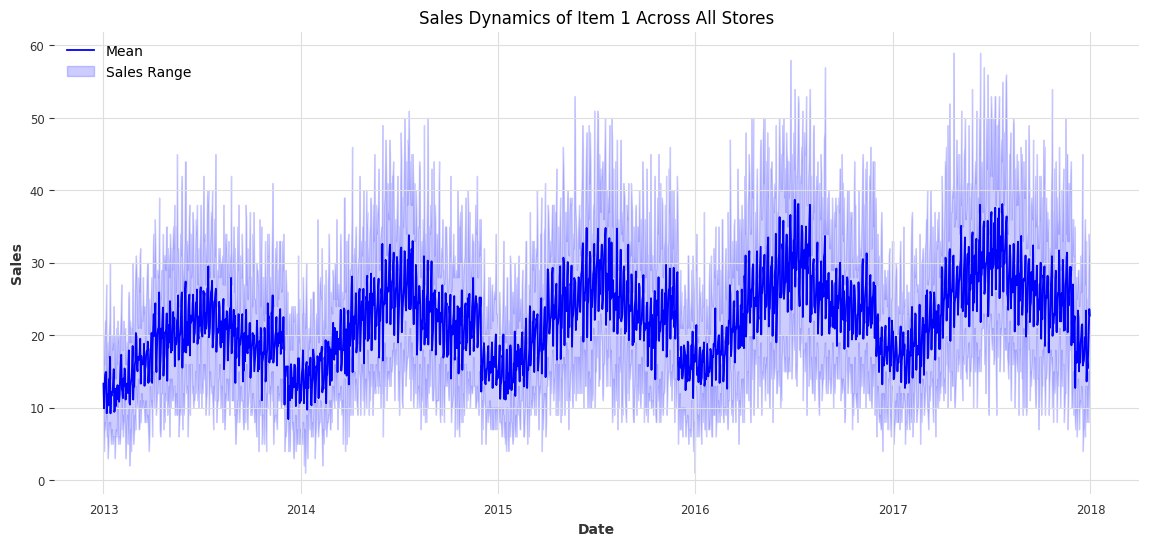

In [9]:
#  Average daily sales for one item across all stores
item_id = 1
df_item = df[df['item'] == item_id].groupby(['date']).agg(
    mean_sales=('sales', 'mean'),
    min_sales=('sales', 'min'),
    max_sales=('sales', 'max')
).reset_index()

plt.figure(figsize=(14,6))
plt.plot(df_item['date'], df_item['mean_sales'], label='Mean', color='blue')
plt.fill_between(df_item['date'], df_item['min_sales'], df_item['max_sales'], color='blue', alpha=0.2, label='Sales Range')
plt.title(f'Sales Dynamics of Item {item_id} Across All Stores')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

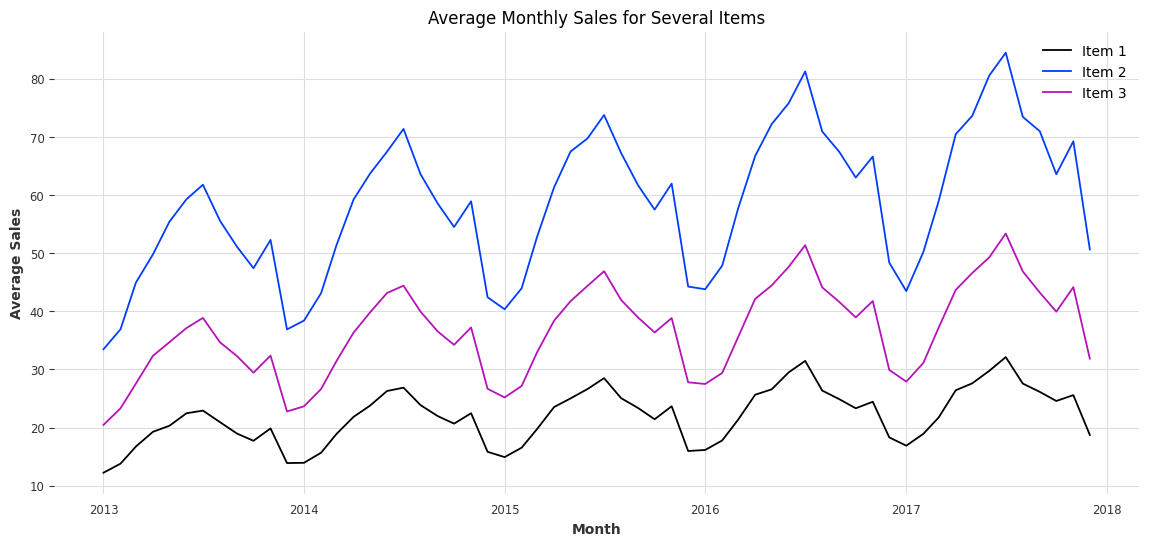

In [10]:
# 2. Average monthly sales for several items
df_monthly = df.copy()
df_monthly['month'] = df_monthly.index.to_period('M')
selected_items = [1, 2, 3]  # example of three items
plt.figure(figsize=(14,6))
for item in selected_items:
    monthly_sales = df_monthly[df_monthly['item'] == item].groupby('month')['sales'].mean()
    plt.plot(monthly_sales.index.to_timestamp(), monthly_sales.values, label=f'Item {item}')
plt.title('Average Monthly Sales for Several Items')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.legend()
plt.show()

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [11]:
subset = df[(df['store'] == 1) & (df['item'] == 1)].copy()

In [12]:
result = seasonal_decompose(subset['sales'], model='additive', period=7)  # period=7 days

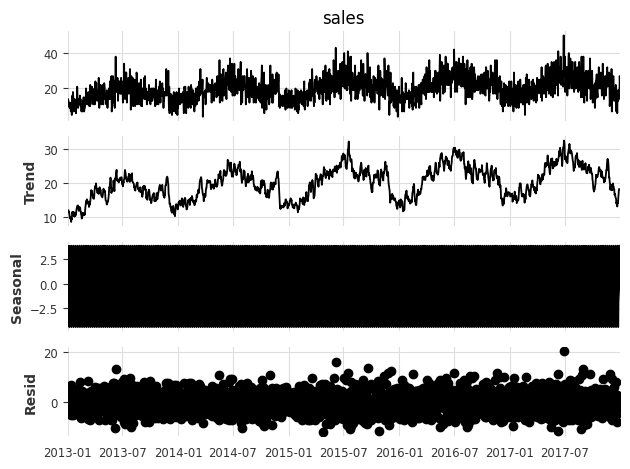

In [13]:
result.plot()
plt.show()

1. Sales (Original Series)

- The original sales series shows clear fluctuations over time, with occasional spikes.  
- There seems to be a general upward and downward movement, suggesting the presence of trends and potential seasonal patterns.

2. Trend

- The trend component captures long-term movements.
- We can observe several rises and falls over the years, indicating periods of increasing and decreasing sales.
- The trend is not strictly linear; it has multiple peaks and troughs, which could correspond to business cycles, promotions, or other external factors.

3. Seasonal

- The seasonal component appears to be flat or constant at zero.
- This indicates that the decomposition could not detect a clear repeating seasonal pattern.
- Possible reasons: The period parameter may not match the true seasonality (e.g., weekly, monthly).
- Noise or irregular fluctuations in sales might be dominating the seasonal signal.
- Missing dates or uneven sampling could distort the seasonal component.

4. Residual

- The residual component shows scattered deviations from the trend.
- There are some spikes, which may indicate unusual events, outliers, or data anomalies.
- The residuals appear relatively consistent in magnitude, though occasional peaks suggest irregular sales behavior.

4. Зі створеної підмножини даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [14]:
series_sales = TimeSeries.from_dataframe(subset, value_cols='sales')
print(series_sales)

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None


5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [15]:
series_sales = series_sales.astype(float)  
val_start = pd.Timestamp('2017-10-01')
train, val = series_sales.split_before(val_start)

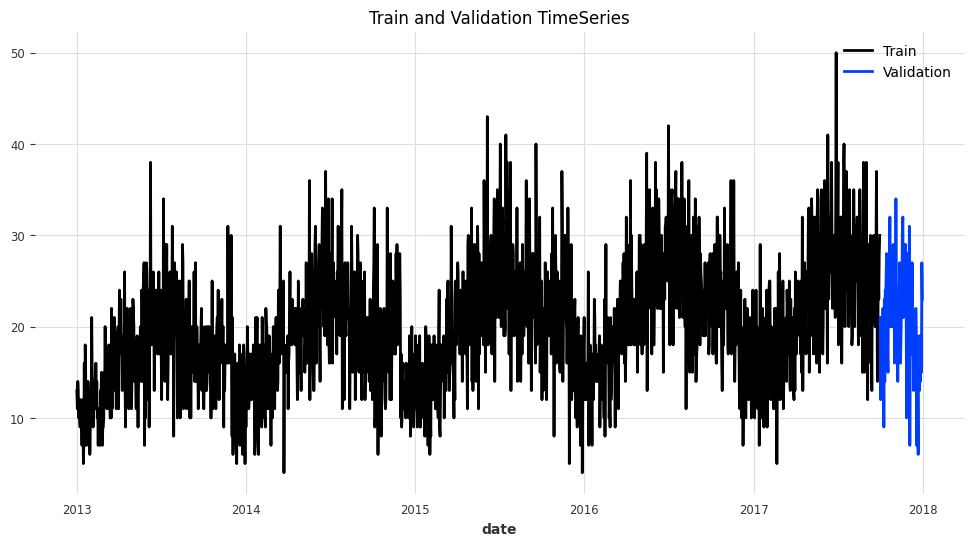

In [16]:
plt.figure(figsize=(12,6))
train.plot(label='Train')
val.plot(label='Validation')
plt.title('Train and Validation TimeSeries')
plt.legend()
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x600 with 0 Axes>

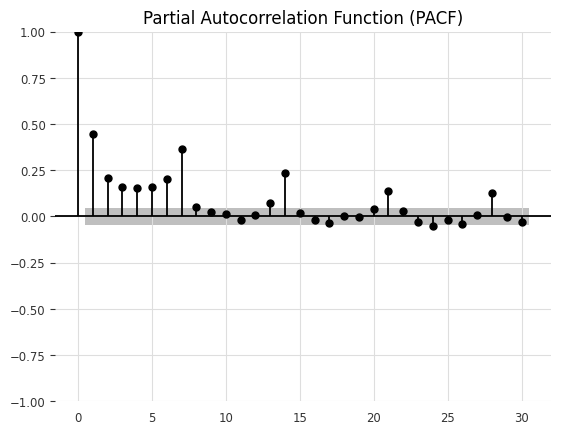

In [17]:
plt.figure(figsize=(10, 6))
plot_pacf(series_sales.values().flatten(), lags=30, method='ywm') 
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

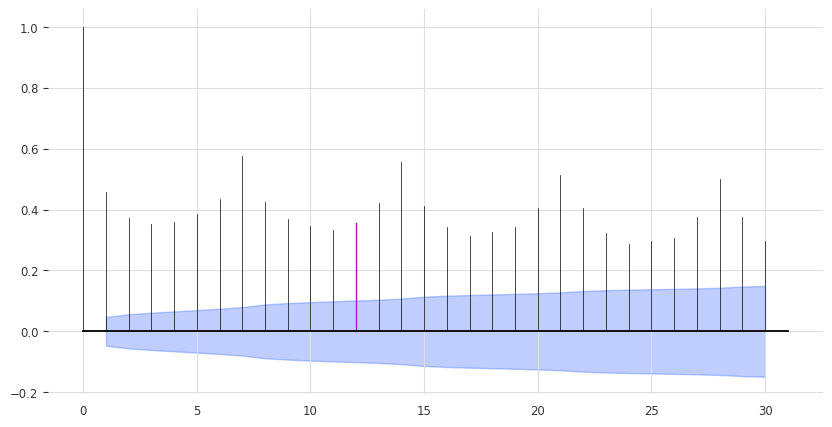

In [18]:
plot_acf(train, m=12, alpha=0.05, max_lag=30)

- Most important: Lag 1 - Very strong positive correlation

- Seasonal Patterns:  
Lag 7 - Moderate positive correlation- Weekly seasonality  
Lag 14 - Weaker positive correlation - 2-week pattern  
Lag 21 - Small positive correlation - 3-week pattern  

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [19]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [20]:
horizon = len(val)

models = {
    "NaiveSeasonal(7)": NaiveSeasonal(K=7),
    "NaiveSeasonal(14)": NaiveSeasonal(K=14),
    "NaiveSeasonal(21)": NaiveSeasonal(K=21),
    "NaiveDrift": NaiveDrift()
}

preds = {}
metrics = {}

for name, model in models.items():
    model.fit(train)
    pred = model.predict(horizon)
    preds[name] = pred
    metrics[name] = {
        "MAE": mae(val, pred),
        "MAPE": mape(val, pred)
    }

for name, m in metrics.items():
    print(f"{name}: MAE = {m['MAE']:.3f}, MAPE = {m['MAPE']:.2f}%")

NaiveSeasonal(7): MAE = 6.120, MAPE = 38.17%
NaiveSeasonal(14): MAE = 6.446, MAPE = 40.24%
NaiveSeasonal(21): MAE = 5.880, MAPE = 37.54%
NaiveDrift: MAE = 10.398, MAPE = 68.74%


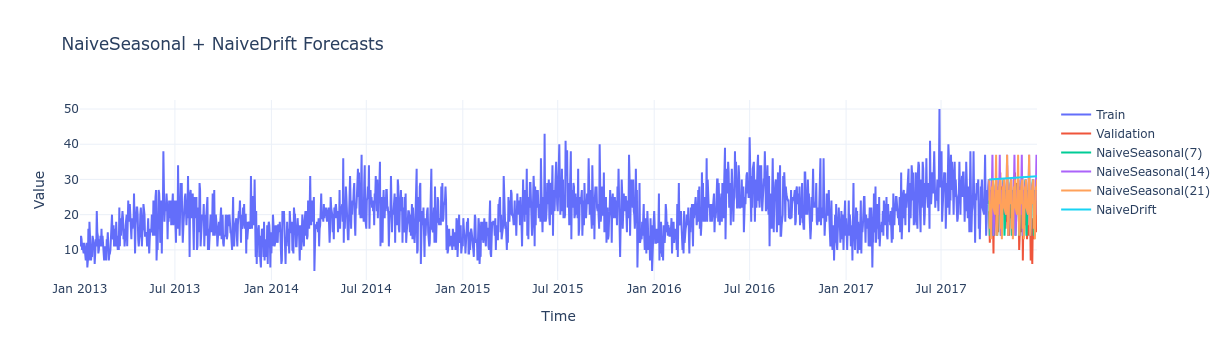

In [21]:
plot_forecasts(
    train=train,       # Darts TimeSeries
    val=val,           # Darts TimeSeries
    preds=preds,       # dict of Darts TimeSeries predictions
    title="NaiveSeasonal + NaiveDrift Forecasts"
)

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

- NaiveSeasonal(21) >> MAE = 5.880, MAPE ≈ 37.5% — this is the best result among all models. It suggests that the series has a clear seasonality of 21 (three weeks), and repeating patterns at this frequency help the model capture the dynamics.

- NaiveSeasonal(7) >> slightly worse (MAE = 6.120, MAPE ≈ 38.2%), which means weekly seasonality is also present, but not as strong as the 21-day cycle.

- NaiveSeasonal(14) >> weaker performance, so the two-week cycle is less important for forecasting.

- NaiveDrift >> much worse (MAE = 10.398, MAPE ≈ 68.7%), which shows that relying on simple drift (trend only) is not appropriate for this series.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [22]:
print("Train length:", len(train), "Val length (horizon):", horizon)

Train length: 1734 Val length (horizon): 92


In [23]:
full_index = series_sales.time_index  # DatetimeIndex

cov_df = pd.DataFrame(index=full_index)
cov_df['dayofweek'] = cov_df.index.dayofweek         # 0=Mon..6=Sun
cov_df['day'] = cov_df.index.day
cov_df['month'] = cov_df.index.month
cov_df['weekofyear'] = cov_df.index.isocalendar().week.astype(int)
cov_df['is_weekend'] = cov_df['dayofweek'].isin([5,6]).astype(int)

# Cyclical transforms for periodic features (avoid one-hot explosion)
cov_df['dow_sin'] = np.sin(2 * np.pi * cov_df['dayofweek'] / 7)
cov_df['dow_cos'] = np.cos(2 * np.pi * cov_df['dayofweek'] / 7)
cov_df['month_sin'] = np.sin(2 * np.pi * (cov_df['month']-1) / 12)
cov_df['month_cos'] = np.cos(2 * np.pi * (cov_df['month']-1) / 12)
cov_df['woy_sin'] = np.sin(2 * np.pi * cov_df['weekofyear'] / 52)
cov_df['woy_cos'] = np.cos(2 * np.pi * cov_df['weekofyear'] / 52)

# Optionally standardize numeric covariates 
covariate_cols = ['dow_sin','dow_cos','month_sin','month_cos','woy_sin','woy_cos','is_weekend','day','weekofyear']
# scale day and weekofyear to ~[0,1]
cov_df['day'] = (cov_df['day'] - cov_df['day'].min()) / (cov_df['day'].max() - cov_df['day'].min())
cov_df['weekofyear'] = (cov_df['weekofyear'] - 1) / 52.0

# pick final columns
cov_df = cov_df[covariate_cols]

# Convert covariates to darts TimeSeries
cov_ts = TimeSeries.from_dataframe(cov_df)  

cov_train = cov_ts.slice_intersect(train)  # covariates aligned with train
cov_full_for_pred = cov_ts  # full covariates (train + val)

In [24]:
#  Build XGBModel
model = XGBModel(
    lags=list(range(-21, 0)),                 # past lags of target
    lags_past_covariates=list(range(-21, 0)), # past lags of covariates
    output_chunk_length=1,
    n_estimators=200,
    random_state=42
)

In [25]:
model.fit(series=train, past_covariates=cov_train)

XGBModel(lags=[-21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1], lags_past_covariates=[-21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1], lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=200)

In [26]:
pred_xgb = model.predict(n=len(val), past_covariates=cov_full_for_pred)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [27]:
#  Evaluate
mae_xgb = mae(val, pred_xgb)
mape_xgb = mape(val, pred_xgb)

In [28]:
results_df = pd.DataFrame(columns=['model', 'MAE', 'MAPE_pct']).set_index('model')

mae_naive21, mape_naive21 = fit_eval_model(NaiveSeasonal(K=21), "NaiveSeasonal21", train, val)
results_df = append_results(results_df, "NaiveSeasonal21", mae_naive21, mape_naive21)
results_df = append_results(results_df,'XGBModel', mae_xgb, mape_xgb)

print(results_df)

NaiveSeasonal21 -> MAE: 5.8804, MAPE: 37.54%
                      MAE   MAPE_pct
model                               
NaiveSeasonal21  5.880435  37.543266
XGBModel         4.606968  25.146428


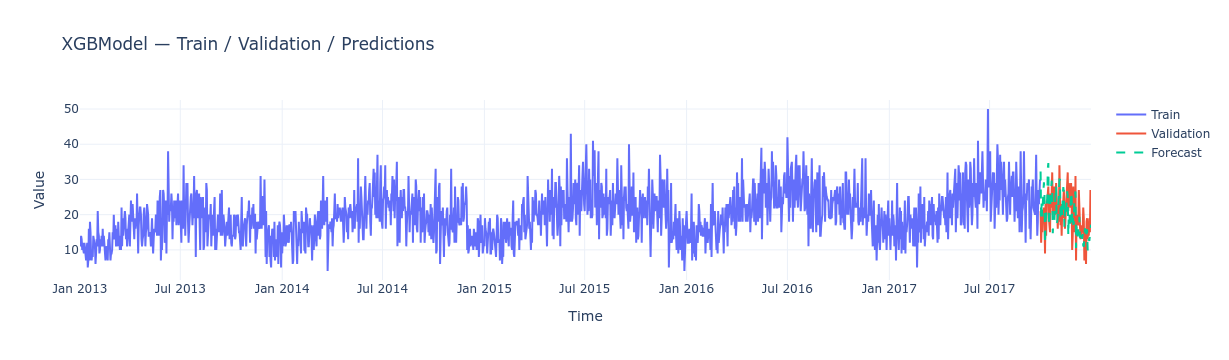

In [29]:
plot_forecasts(
    train=train,        
    val=val,            
    preds=pred_xgb,     
    title="XGBModel — Train / Validation / Predictions"
)


1. The XGBModel significantly outperforms the naive seasonal benchmark — MAPE drops from ~37.5% to ~25%.

2. This improvement shows that the model successfully captures:

- non-linear relationships,  
- interactions with date features (day-of-week, month, week-of-year, weekend flag),  
- and seasonal patterns up to 3 weeks (via lags).

3. NaiveSeasonal(21) only repeats past seasonal patterns, ignoring finer trends or calendar interactions, which is why its error is higher.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [30]:
mae_es, mape_es = fit_eval_model(ExponentialSmoothing(), "ExponentialSmoothing", train, val)
results_df = append_results(results_df, "ExponentialSmoothing", mae_es, mape_es)

ExponentialSmoothing -> MAE: 5.7073, MAPE: 39.01%


In [31]:
results_df 

,MAE,MAPE_pct
model,,
NaiveSeasonal21,5.880435,37.543266
XGBModel,4.606968,25.146428
ExponentialSmoothing,5.707340,39.012841


12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [32]:
mae_arima, mape_arima = fit_eval_model(ARIMA(), "ARIMA", train, val)
results_df = append_results(results_df, "ARIMA", mae_arima, mape_arima)

ARIMA -> MAE: 5.7762, MAPE: 39.49%


13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

In [33]:
def find_optimal_arima_darts(train_ts, val_ts, seasonal=True, seasonal_period=None):
    # Convert Darts TimeSeries to numpy arrays
    train_values = train_ts.values().flatten()
    val_values = val_ts.values().flatten()
    
    # Auto-detect seasonal period if not provided
    if seasonal and seasonal_period is None:
        seasonal_period = min(12, len(train_values)//10) if len(train_values) > 100 else 7
        print(f"Auto-detected seasonal period: {seasonal_period}")
    
    # Adaptive parameter ranges
    n = len(train_values)
    if n < 50: max_p, max_q, max_P, max_Q = 2, 2, 1, 1
    elif n < 200: max_p, max_q, max_P, max_Q = 3, 3, 2, 2
    else: max_p, max_q, max_P, max_Q = 5, 5, 2, 2
    print(f"Parameter ranges: p≤{max_p}, q≤{max_q}, P≤{max_P}, Q≤{max_Q}")
    
    # AutoARIMA
    try:
        model = auto_arima(
            train_values, start_p=0, start_q=0, max_p=max_p, max_q=max_q,
            d=None, start_P=0, start_Q=0, max_P=max_P, max_Q=max_Q,
            D=None, seasonal=seasonal, m=seasonal_period if seasonal else 1,
            stepwise=True, approximation=True, trace=True,
            error_action='ignore', suppress_warnings=True, maxiter=50,
            random_state=42
        )
    except:
        # Fallback simpler search
        model = auto_arima(train_values, start_p=1, start_q=1, max_p=3, max_q=3,
                           seasonal=False, stepwise=True, approximation=True,
                           error_action='ignore', suppress_warnings=True, random_state=42)
    
    order = model.order
    seasonal_order = getattr(model, 'seasonal_order', (0,0,0,0))
    
    # Forecast
    forecast = model.predict(n_periods=len(val_values))
    
    # Metrics
    mae = mean_absolute_error(val_values, forecast)
    rmse = np.sqrt(mean_squared_error(val_values, forecast))
    mape = np.mean(np.abs((val_values - forecast) / val_values)) * 100
    
    print(f"\nOptimal ARIMA order: {order}")
    if seasonal_order != (0,0,0,0): print(f"Seasonal order: {seasonal_order}")
    print(f"AIC: {model.aic():.2f}, BIC: {model.bic():.2f}")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
    
    
    return {
        'model': model,
        'order': order,
        'seasonal_order': seasonal_order,
        'forecast': forecast,
        'metrics': {'mae': mae, 'rmse': rmse, 'mape': mape}
    }


results = find_optimal_arima_darts(train, val, seasonal=True, seasonal_period=7)
print(f"Best MAE: {results['metrics']['mae']:.4f}")

Parameter ranges: p≤5, q≤5, P≤2, Q≤2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11699.312, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11207.039, Time=0.87 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10659.514, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11697.315, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10763.373, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.86 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10587.183, Time=2.30 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=7.58 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=11549.258, Time=1.23 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10580.615, Time=2.42 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10652.927, Time=1.17 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=7.50 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.90 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=11181.391, Time=1.23 sec
 ARIMA

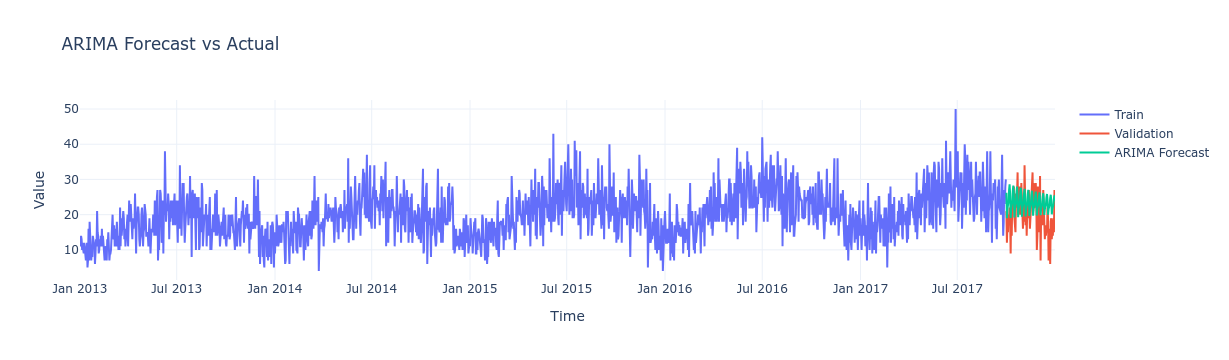

In [34]:
forecast_ts = TimeSeries.from_times_and_values(val.time_index, results['forecast'])

plot_forecasts(
    train=train,
    val=val,
    preds={'ARIMA Forecast': forecast_ts},
    title="ARIMA Forecast vs Actual"
)

In [35]:
results_df = append_results(results_df, "AutoARIMA", results['metrics']['mae'], results['metrics']['mape'])
results_df

,MAE,MAPE_pct
model,,
NaiveSeasonal21,5.880435,37.543266
XGBModel,4.606968,25.146428
ExponentialSmoothing,5.707340,39.012841
ARIMA,5.776212,39.492251
AutoARIMA,5.096725,34.176201


14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [36]:
train_prophet = pd.DataFrame({
    'ds': train.time_index,        
    'y': train.values().flatten()
})

val_prophet = pd.DataFrame({
    'ds': val.time_index,
    'y': val.values().flatten()
})

In [37]:
# Initialize and fit Prophet model
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
model.fit(train_prophet)

# Forecast for validation period
future = val_prophet[['ds']].copy()
forecast = model.predict(future)

# Extract predictions and true values
y_pred = forecast['yhat'].values
y_true = val_prophet['y'].values

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
results_df = append_results(results_df, "Prophet", mae, mape)

13:39:16 - cmdstanpy - INFO - Chain [1] start processing
13:39:16 - cmdstanpy - INFO - Chain [1] done processing


MAE: 5.3349, RMSE: 6.5782, MAPE: 36.40%


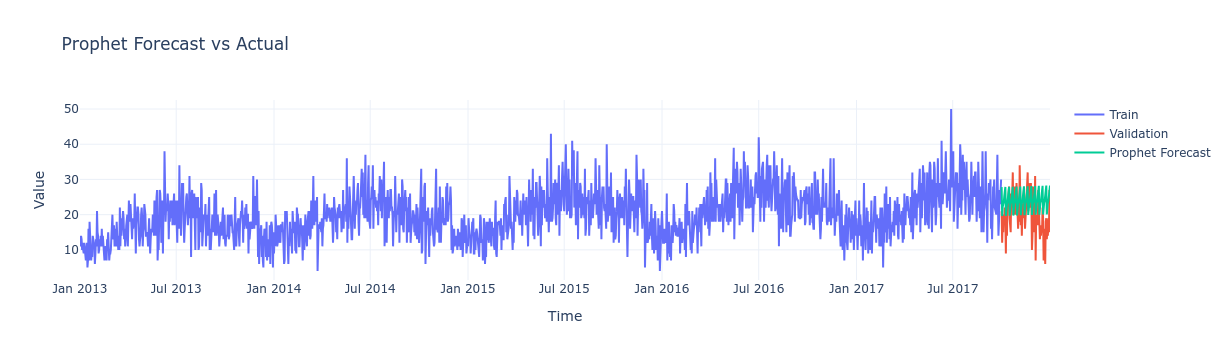

In [38]:
y_pred_flat = np.array(y_pred).flatten()

forecast_df = pd.DataFrame({
    'ds': val_prophet['ds'],
    'y': y_pred_flat
})

plot_forecasts(
    train=train_prophet,
    val=val_prophet,
    preds={'Prophet Forecast': forecast_df},
    time_col='ds',
    value_col='y',
    title="Prophet Forecast vs Actual"
)


15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [39]:
# Ensure input_chunk_length and training_length fit the series
input_chunk_length = max(1, min(12, len(train)-1))
training_length = max(input_chunk_length, min(20, len(train)))
batch_size = min(32, len(train) - input_chunk_length)  # safe batch size

model = RNNModel(
    model='LSTM',
    hidden_dim=25,
    n_rnn_layers=2,
    dropout=0.1,
    input_chunk_length=input_chunk_length,
    training_length=training_length,
    batch_size=batch_size,
    n_epochs=10,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42
)

# Fit & evaluate
model.fit(train)
forecast = model.predict(len(val))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [47]:
print("val shape:", val.shape if hasattr(val, 'shape') else f"type: {type(val)}, length: {len(val) if hasattr(val, '__len__') else 'no length'}")
print("forecast shape:", forecast.shape if hasattr(forecast, 'shape') else f"type: {type(forecast)}, length: {len(forecast) if hasattr(forecast, '__len__') else 'no length'}")
print("val sample:", val[:5] if hasattr(val, '__len__') else val)
print("forecast sample:", forecast[:5] if hasattr(forecast, '__len__') else forecast)

val shape: (92, 1, 1)
forecast shape: (92, 1, 1)
val sample: <TimeSeries (DataArray) (date: 5, component: 1, sample: 1)> Size: 40B
array([[[21.]],

       [[12.]],

       [[18.]],

       [[15.]],

       [[20.]]])
Coordinates:
  * date       (date) datetime64[ns] 40B 2017-10-01 2017-10-02 ... 2017-10-05
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None
forecast sample: <TimeSeries (DataArray) (date: 5, component: 1, sample: 1)> Size: 40B
array([[[14.94349133]],

       [[14.94340254]],

       [[14.94340096]],

       [[14.94340098]],

       [[14.94340101]]])
Coordinates:
  * date       (date) datetime64[ns] 40B 2017-10-01 2017-10-02 ... 2017-10-05
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None


In [51]:
mae_val = mae(val, forecast)
mape_val = mape(val, forecast)

results_df = append_results(results_df, "LSTM_RNN", mae_val, mape_val)
print(results_df)
print(f"input_chunk_length: {input_chunk_length}, training_length: {training_length}, batch_size: {batch_size}")

                           MAE   MAPE_pct
model                                    
NaiveSeasonal21       5.880435  37.543266
XGBModel              4.606968  25.146428
ExponentialSmoothing  5.707340  39.012841
ARIMA                 5.776212  39.492251
AutoARIMA             5.096725  34.176201
Prophet               5.334942  36.402902
LSTM_RNN              6.376329  30.665838
input_chunk_length: 12, training_length: 20, batch_size: 32


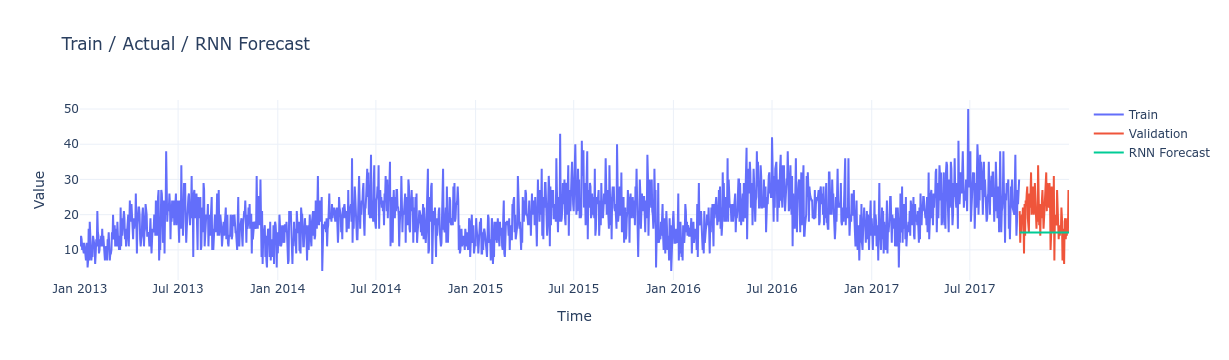

In [52]:
plot_forecasts(
    train=train,
    val=val,
    preds={'RNN Forecast': forecast},
    title="Train / Actual / RNN Forecast"
)

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [53]:
# Forecast horizon and backtest period
forecast_horizon = 30  # 1 month ahead 
backtest_period = 365   # last 1 year for backtest

# Initialize model
model = XGBModel(
    lags=7,         
    n_estimators=100,
    random_state=42
)

# Perform historical forecasts (backtest)
backtest_forecast = model.historical_forecasts(
    series=train,
    start=len(train)-backtest_period,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,  
    retrain=True,
    verbose=True
)

# Actual values for comparison
actual = train[-backtest_period:]

# Calculate backtest metrics
mae_backtest = mae(actual, backtest_forecast)
mape_backtest = mape(actual, backtest_forecast)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (365,) (12,) 

In [ ]:
print(f"XGBModel Backtest Accuracy:")
print(f"MAE: {mae_backtest:.4f}, MAPE: {mape_backtest:.2f}%")
results_df = append_results(results_df, "XGBModel_backtest", mae_backtest, mape_backtest)
results_df

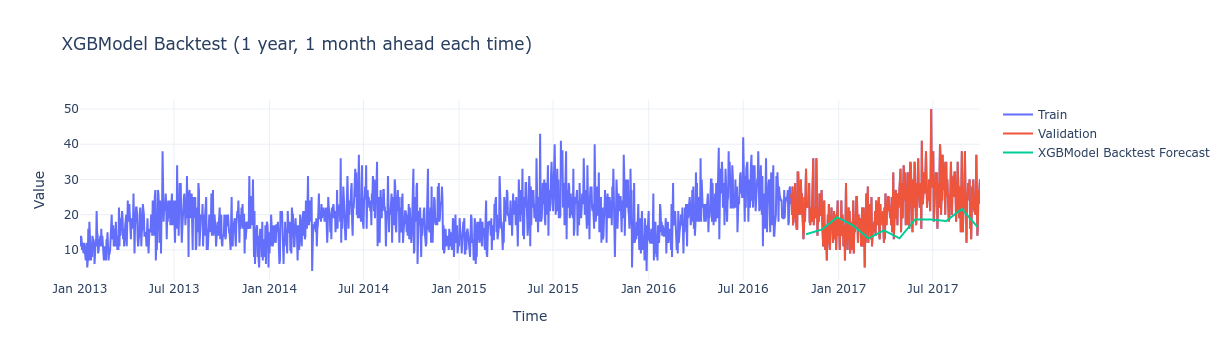

In [54]:
if isinstance(backtest_forecast, list):
    backtest_forecast = reduce(lambda a, b: a.concatenate(b), backtest_forecast)
 
plot_forecasts(
    train=train,
    val=actual,
    preds={'XGBModel Backtest Forecast': backtest_forecast},
    title="XGBModel Backtest (1 year, 1 month ahead each time)"
)

In [55]:
def simple_grid_search(train_data, val_data, max_trials=30):
    """
    Simple but effective grid search for XGBModel
    """
    print("Starting Simple Grid Search...")
    
    # Define focused parameter combinations
    param_options = {
        'lags': [7, 14, 21, 30],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.1, 0.15, 0.2]
    }
    
    best_score = float('inf')
    best_params = None
    best_model = None
    
    # Generate parameter combinations
    param_names = list(param_options.keys())
    param_values = list(param_options.values())
    all_combinations = list(itertools.product(*param_values))
    
    # Limit to max_trials
    test_combinations = all_combinations[:max_trials]
    
    print(f"Testing {len(test_combinations)} parameter combinations...")
    
    for i, combination in enumerate(test_combinations):
        params = dict(zip(param_names, combination))
        
        score, model = evaluate_xgb_params(train_data, val_data, params)
        
        if score < best_score:
            best_score = score
            best_params = params.copy()
            best_model = model
            print(f"New best score: {best_score:.4f} with params: {best_params}")
        
        if (i + 1) % 10 == 0:
            print(f"Completed {i+1}/{len(test_combinations)} combinations")
    
    print(f"Grid Search Complete!")
    print(f"Best MAE: {best_score:.4f}")
    print(f"Best parameters: {best_params}")
    
    return best_params, best_score, best_model


In [56]:
best_params, best_score, best_model = simple_grid_search(train_split, val_split, max_trials=50)

NameError: name 'train_split' is not defined

In [57]:
# Forecast horizon and backtest period
forecast_horizon = 30   # 1 month ahead
backtest_period = 365   # last 1 year for backtest

# Initialize model with best parameters
model = XGBModel(
    lags=14,             # tuned lag length
    n_estimators=100,    # tuned number of trees
    max_depth=6,         # tuned tree depth
    learning_rate=0.1,   # tuned learning rate
    random_state=42
)

# Perform historical forecasts (backtest)
backtest_forecast = model.historical_forecasts(
    series=train,
    start=len(train)-backtest_period,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,   # forecast in 1-month steps
    retrain=True,
    verbose=True,
    last_points_only=False
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]

In [58]:
# Actual values for comparison
actual = train[-backtest_period:]

mae_list = []
mape_list = []

# iterate over forecast windows
for i in range(len(backtest_forecast)):
    start_idx = i * forecast_horizon
    end_idx = start_idx + forecast_horizon
    y_true = actual[start_idx:end_idx].values()
    y_pred = backtest_forecast[i].values()  # each forecast is a TimeSeries
    mae_list.append(mean_absolute_error(y_true, y_pred))
    mape_list.append(mean_absolute_percentage_error(y_true, y_pred))

# Average across all windows
mae_backtest = np.mean(mae_list)
mape_backtest = np.mean(mape_list)

print("Backtest MAE:", mae_backtest)
print("Backtest MAPE:", mape_backtest)

results_df = append_results(results_df, "XGBModel_backtest_tuned", mae_backtest, mape_backtest)
results_df

Backtest MAE: 4.698191409640843
Backtest MAPE: 0.24230020898909665


,MAE,MAPE_pct
model,,
NaiveSeasonal21,5.880435,37.543266
XGBModel,4.606968,25.146428
ExponentialSmoothing,5.707340,39.012841
ARIMA,5.776212,39.492251
AutoARIMA,5.096725,34.176201
Prophet,5.334942,36.402902
LSTM_RNN,6.376329,30.665838
XGBModel_backtest_tuned,4.698191,0.242300


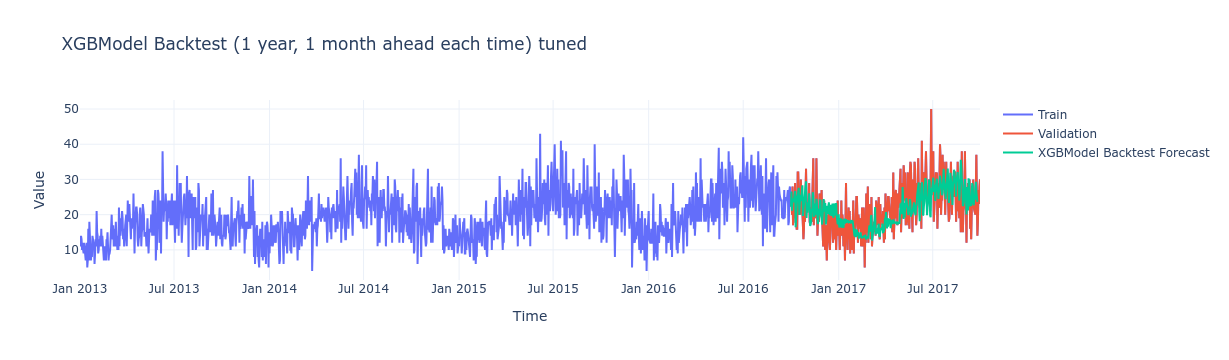

In [59]:
if isinstance(backtest_forecast, list):
    backtest_forecast = reduce(lambda a, b: a.concatenate(b), backtest_forecast)
 
plot_forecasts(
    train=train,
    val=actual,
    preds={'XGBModel Backtest Forecast': backtest_forecast},
    title="XGBModel Backtest (1 year, 1 month ahead each time) tuned"
)

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

1. Model Choice

- Main model: A global model trained on all 500 series at once.  
- Best practical choice: XGBoost(fast, interpretable).

2. Number of Models

- One global model for all series.  
- Optionally: A few local models for top/critical items if needed.

So: 1–3 models total, not 500.

3. Why Global Models?

- Efficiency: Training 500 local models is impractical.  
- Knowledge sharing: Global models learn shared patterns (seasonality, promo effects).  
- Flexibility: Easy to add features (calendar, promo, prices, store/item IDs).
- Scalability: Easier to deploy & maintain.

4. Features

- Lags: 1, 7, 14, 30.  
- Rolling means: 7/14/30 days.  
- Calendar: day of week, month, holidays.  
- Business: promos, prices, stock.  
- IDs: item_id, store_id (categorical features)  
- Aggregates: store/item/category totals.

5. Validation

- Backtest with forecast horizon = 30 days, stride = 30.
- Metrics: MAE, MAPE, SMAPE (and service-level for intermittent series).

6. Deployment

- Retrain weekly/monthly.
- Monitor per-series error.

### Summary:

Train one global LightGBM/XGBoost model on all 500 series with lags, calendar, and business covariates.   
Use a separate intermittent-demand model for sparse series.   
Total ~1–3 models. This is efficient, scalable, and captures shared sales patterns across items/stores.  